In [8]:
import torch
from IPython import  display
from d2l import torch as d2l
import torchvision  # pytorch 关于计算机视觉实现的一个库
from torch.utils import data
from torchvision import transforms  # 对数据进行一些操作

class torchvision.transforms.Compose(transforms):
 # Composes several transforms together.
 # Parameters: transforms (list of Transform objects) – list of transforms to compose.
 
Example # 可以看出Compose里面的参数实际上就是个列表，而这个列表里面的元素就是你想要执行的transform操作。
>>> transforms.Compose([
>>>     transforms.CenterCrop(10),
>>>     transforms.ToTensor(),])


python insert()函数用于将指定对象插入列表的指定位置。
list.insert(index, obj)
1
参数：

index：对象obj需要插入的索引位置。

obj：要插入列表中的对象。

data.DataLoader
    dataset：（数据类型 dataset）
    batch_size：（数据类型 int）
    shuffle：（数据类型 bool）
    batch_sampler：（数据类型 Sampler）
    sampler：（数据类型 Sampler）
    num_workers：（数据类型 Int）
    pin_memory：（数据类型 bool）
    drop_last：（数据类型 bool）
    timeout：（数据类型 numeric）
    使用示例

In [9]:
# 设置读取图片的进程数
def get_dataloader_process():
    return 6

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    # 如果需要给img重新修改尺寸的话
    if resize:
        # 在第0号index插入图像缩放变换，目的是先对图像进行尺寸变换
        trains.insert(0, transforms.Resize(resize))
    # transforms.Compose 拼接图像处理的操作 这里是把图像的尺度变换和别的变换连接起来
    trans = transforms.Compose(trans)
    # transform=trans 将图片转为tensor download=True 默认从网上下载 download=flase 默认使用本地的数据集
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",train=True, transform=trans, download=False)
    # 下载测试数据集
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=False)
    return(
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_process()),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_process())
    )

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [10]:
# 图片的尺寸为28*28 这里要把图片展开成一维向量
num_inputs = 28*28
# 模型的输出有10个类
num_outputs = 10

# softmax 的输入是一个概率向量，所以要把图片拉长成一个一维的向量，权重W的行数为输入图像展成一维向量的像素个数，列数为输出的个数
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
# 偏移 长为10的向量  这里初始化为0
b = torch.zeros(num_outputs, requires_grad=True)

torch.sum()/tensor.sum(): 求和运算。若指定dim，则计算dim方向上的和，并且维度缩小1；若未指定dim，则计算总和，返回一个scalar；若设置keepdim=True，则维持输入输出维度一致。
(**
$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$
**)

In [11]:
# X 是一个矩阵，对X的每一行做softmax
def softmax(X):
    # 目前理解为给X的每一个像素做一个质数运算
    X_exp = torch.exp(X)
    # X 按行求和, 
    partition = X_exp.sum(1,keepdim=True) # 依然保持其二维矩阵的样子
    # 运用广播机制计算每一个元素的指数值占指数和的百分比，这里的sum要扩充纬度
    return X_exp / partition

In [7]:
# 测试

X = torch.normal(0, 1, (2, 5))
print(X)
print(torch.exp(X))
print(torch.exp(X).sum(1, keepdim=True))

x_prob = softmax(X)
x_prob, x_prob.sum(1)

tensor([[-0.6680,  0.8049, -0.4200, -0.6775, -1.0827],
        [ 0.1031,  1.9676,  0.4823, -0.7428, -0.5180]])
tensor([[0.5127, 2.2365, 0.6571, 0.5079, 0.3387],
        [1.1086, 7.1532, 1.6198, 0.4758, 0.5957]])
tensor([[ 4.2529],
        [10.9532]])


(tensor([[0.1206, 0.5259, 0.1545, 0.1194, 0.0796],
         [0.1012, 0.6531, 0.1479, 0.0434, 0.0544]]),
 tensor([1.0000, 1.0000]))

In [12]:
# 定义softmax回归模型，也就是y_hat的输出
def net(X):
    """
        -1:让torch自己算 这里的纬度算出来的数值应该是批量batch_size大小
        W.shape[0] 也就是之前提到的 img_long * img_width (28*28)
        X.reshape((-1, W.shape[0])) X会被reshape成一个 batch_size *  (img_long * img_width)  的二维向量
        torch.matmul是tensor的乘法, 输入可以是高维的 当输入是都是二维时, 就是普通的矩阵乘法, 当输入有多维时, 把多出的一维作为batch提出来, 其他部分做矩阵乘法。
        torch.matmul(X.reshape((-1, W.shape[0])), W) 得到一个 [batch_size * 10] 一个tensor
        softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b) 得到 [batch_size * 10] 的tensor 其中第i行的第j项都代表第i个图像属于第j类的概率
    """
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b) # 这里应该也用了广播机制

In [21]:
# 测试
# [0, 1] 相当于做是y_hat元素的索引， y相当于是元素类别的索引
# 这里的y是假设已经知道了这两个样本的的真实类别，0表示第一个样本，2表示第三个样本
# 其实本质就是获取y_hat在(0, 0)以及(1, 2)处的元素

y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# [0,1] 是y_hat的纬度索引， y 是y_hat某一纬度数据的的索引,在这个例子中y是指具体用哪一类别的事物的概率算交叉熵
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [13]:
# 实现交叉损失函数
def cross_entropy(y_hat, y):
    # y 应该是一个[batch_size * 1] 的一个tensor  其中每一行的数字代表标签上的该图片所属的种类下标
    # 注意这里的标签值y，并不参与直接计算，而是作为一个索引,索引对象为实际类别
    return -torch.log(y_hat[range(len(y_hat)), y])
# cross_entropy(y_hat, y)

# 显示准确度，返回这一批数据预测准确的个数
def accuracy(y_hat, y):
    """显示正确预测物体类别的概率

    Args:
        y_hat (_type_): _description_
        y (_type_): _description_
    """

    # 此时的y_hat 是 batch_size * 10 的张量, 每i行对应第i张图之于10个物品的概率的列表
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        # 取出来 y_hat每一行中最大概率对应的下标 axis = 1 表示按行取出
        y_hat = y_hat.argmax(axis = 1)
        # 由于等式运算符“==”对数据类型很敏感，因此将y_hat的数据类型转换为与y的数据类型⼀致。结果是⼀个包含0（错）和1（对）的张量
        # torch.Tensor.type()该方法的功能是:当不指定dtype时,返回类型; 当指定dtype时,返回类型转换后的数据,如果类型已经符合要求,那么不做额外的复制,返回原对象.
        cmp = y_hat.type(y.dtype) == y
    # 这里是布尔类型先转成int型再求和，求和后再转float型
    return float(cmp.type(y.dtype).sum())

# accuracy(y_hat, y) / len(y)

isinstance() 函数来判断一个对象是否是一个已知的类型，类似 type()。

isinstance() 与 type() 区别：

    type() 不会认为子类是一种父类类型，不考虑继承关系。

    isinstance() 会认为子类是一种父类类型，考虑继承关系。

如果要判断两个类型是否相同推荐使用 isinstance()。

In [14]:
class Accumulator: #@save
    """在n个变量上累加, 算准确率的时候用的"""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# 一个评估模型准确率的通用函数
def evaluate_accuracy(net, data_iter):
    """计算指定模型 （net）上的 精度

    Args:
        net (_type_): 具体某一个模型
        data_iter (_type_): _description_
    """
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式, 不要再计算梯度了
    # Accumulator()准确率中的一个实用程序类 https://blog.csdn.net/weixin_44556141/article/details/120116161
    metric = Accumulator(2) # 正确预测数，预测总数
    for X, y in data_iter:
        # numel就是"number of elements"的简写。numel()可以直接返回int类型的元素个数
        metric.add(accuracy(net(X),y), y.numel())
    return metric[0] / metric[1]

# evaluate_accuracy(net, test_iter)

0.0675

In [15]:

# 定义⼀个函数来训练⼀个迭代周期
# updater是更新模型参数的常⽤函数，它接受批量⼤⼩作为参数。它可以是d2l.sgd函数，也可以是框架的内置优化函数
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        # 如果模型是torch的的实现，则打开训练模式，这里会更新数据的权重
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        # 计算损失
        l = loss(y_hat, y)
        # 如果#使⽤PyTorch内置的优化器和损失函数
        if isinstance(updater, torch.optim.Optimizer):
            # 首选把上次训练的梯度清零
            updater.zero_grade()
            l.backward()
            updater.step()
            # 这里的float(l)*len(y)我猜是采用torch自带的Optimizer的话，loss会直接计算mse，乘len(y)就变回和l.sum()一样的整个batch的loss和了
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            # 使⽤定制的优化器和损失函数
            l.sum().backward()
            # d2l.sgd
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [16]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [17]:
# 定义训练函数
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                    legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

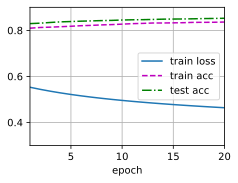

In [19]:
lr = 0.2
num_epochs = 20

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

train_ch3(net, test_iter, test_iter, cross_entropy, num_epochs, updater)